<a href="https://colab.research.google.com/github/vkatta5/MIS64061/blob/main/Classifying_Misinformation_using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Requirements

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.9 MB/s 
     |████████████████████████████████| 7.6 MB 50.6 MB/s 
     |████████████████████████████████| 182 kB 62.8 MB/s 


# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
nltk.download('stopwords')

import seaborn as sns
from matplotlib.pylab import plt
import time
import datetime
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# EDA and Configurations

In [ ]:
news_data = pd.read_csv('/content/WELFake_Dataset.csv')

In [ ]:
class_names = ['fake', 'real'] 

In [ ]:
news_data.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [ ]:
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [ ]:
news_data.isnull().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

In [ ]:
news_data = news_data.fillna('')

In [ ]:
news_data.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [ ]:
news_data.nunique()

Unnamed: 0    72134
title         62348
text          62719
label             2
dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Target Count')

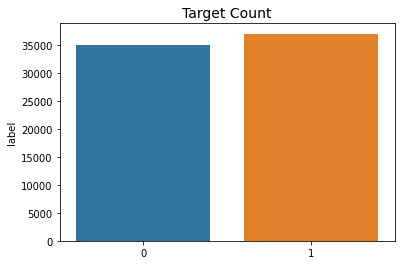

In [ ]:
label_count = news_data.label.value_counts()
sns.barplot(label_count.index, label_count)
plt.title('Target Count', fontsize=14)

# Preparing Dataset

Stemming & Extracting text data using TF-IDF

In [ ]:
port = PorterStemmer()

def stemming(text):
    stem_text = re.sub('[^a-zA-Z]', ' ', text)
    stem_text = stem_text.lower()
    stem_text = stem_text.split()
    
    stem_text = [port.stem(word) for word in stem_text if not word in stopwords.words('english')]
    stem_text = ' '.join(stem_text)
    
    return stem_text

In [ ]:
def refinement_tfidf(text): # TF-IDF
    ex = text.split('.')
    ex = pd.DataFrame(ex)[0].apply(stemming)
    
    if ex[0] == '':
        return text
    
    vectorizer = TfidfVectorizer()
    try:
        vectorizer.fit(ex)
        features = vectorizer.transform(ex)
    except:
        return text
    
    feature_names = np.array(vectorizer.get_feature_names())
    feature_count = features.toarray().mean(axis=0)
    
    refined_text = ' '.join(feature_names[feature_count > 0.05]) # setting the importance weights according to TF-IDF
    
    return refined_text

In [ ]:
t0 = time.time()
news_data['refined_tfidf'] = news_data['text'].apply(refinement_tfidf)
print(time.time() - t0)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


5472.702614307404


In [ ]:
news_data.head()

,Unnamed: 0,title,text,label,refined_tfidf
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,said
1,1,,Did they post their votes for Hillary already?,1,alreadi hillari post vote
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,aka chang constitut creat demonstr eric exerci...
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,jindal
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,design dub km mile missil rs sarmat satan weapon


In [ ]:
labels = news_data['label'].values
texts = (news_data['title'] + ' ' + news_data['refined_tfidf']).values

# Tokenization

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
idx = np.random.choice(range(len(texts)))
print(texts[idx])
# Tokenized
print(tokenizer.tokenize(texts[idx]))
# Token to Integral
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(texts[idx])))

New rules give protesters more leeway at Republican convention cleveland demonstr event mile new plan squar zone
['new', 'rules', 'give', 'protesters', 'more', 'lee', '##way', 'at', 'republican', 'convention', 'cleveland', 'demons', '##tr', 'event', 'mile', 'new', 'plan', 'sq', '##ua', '##r', 'zone']
[2047, 3513, 2507, 13337, 2062, 3389, 4576, 2012, 3951, 4680, 6044, 7942, 16344, 2724, 3542, 2047, 2933, 5490, 6692, 2099, 4224]


In [ ]:
max_len = 0
id_len = []
for text in texts:
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    if len(input_ids) > 200:
        continue
    id_len.append(len(input_ids))
    max_len = max(max_len, len(input_ids))
print('Max sentence length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (945 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  197


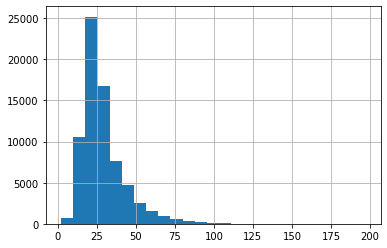

In [ ]:
pd.Series(id_len).hist(bins=25)

In [ ]:
def tokenize_map(sentence, labs='None'):
    global labels
    input_ids = []
    attention_masks = []
    for text in sentence:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens = True, # [CLS] & [SEP]
                            truncation = 'longest_first', # Control truncation
                            max_length = 100, # Max length about texts
                            pad_to_max_length = True, # Pad and truncate about sentences
                            return_attention_mask = True, # Attention masks
                            return_tensors = 'pt') # Return to pytorch tensors
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    if labs != 'None':
        labels = torch.tensor(labels)
        return input_ids, attention_masks, labels
    else:
        return input_ids, attention_masks

In [ ]:
input_ids, attention_masks, labels = tokenize_map(texts, labels)

dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
len(train_dataset.indices), len(val_dataset.indices)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
<ipython-input-21-f6ebc5a4944a>:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if labs != 'None':


(57707, 14427)

In [ ]:
batch_size = 32
num_workers = 4

train_loader = DataLoader(
                dataset=train_dataset,
                batch_size=batch_size,
                shuffle=True,
                num_workers=num_workers)

val_loader = DataLoader(
                dataset=val_dataset,
                batch_size=1,
                shuffle=False)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Loading Deep Learning Model

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2,
        output_attentions=False,
        output_hidden_states=False)
model.to(device)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=6e-6,
                              eps=1e-8)

In [ ]:
num_epochs = 10
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# Model Training

In [ ]:
model.train()

total_step = len(train_loader)
for epoch in range(num_epochs):
    total_loss = 0
    for i, (ids, masks, labels) in enumerate(train_loader):
        ids = ids.to(device)
        masks = masks.to(device)
        labels = labels.to(device)
        
        loss = model(ids, token_type_ids=None, attention_mask=masks, labels=labels)[0]
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        
        if (i+1) % 100 == 0:
            print('{} / {}'.format(batch_size*(i+1), train_dataset.__len__()))
            
    print('Epoch: {}, Loss: {:.4f}'.format(epoch+1, total_loss / total_step))
            
torch.save(model.state_dict(), 'nets/BERT.ckpt')

3200 / 57707


# Model Evaluation

In [ ]:
model.eval()
model.load_state_dict(torch.load('nets/BERT.ckpt', map_location=device))

# Scoring Accuracy

In [ ]:
score = 0
for i, (ids, masks, labels) in enumerate(val_loader):
    ids = ids.to(device)
    masks = masks.to(device)
    labels = labels.to(device)

    g_labels = model(ids, token_type_ids=None, attention_mask=masks, labels=labels)[1]
    
    pred = torch.max(g_labels, 1)[1][0].item()
    gt = labels[0].item()
    
    score += int(pred == gt)

avg = score / len(val_dataset)
print('Accuracy: {:.4f}\n'.format(avg))

A total accuracy of over 95% reached on implementing the model.